In [182]:
# imports

import torch
import pandas as pd
import matplotlib.pyplot as plt

from utils import ProjectFolders

In [183]:
from sklearn.model_selection import train_test_split

df_final = pd.read_csv(ProjectFolders.FINAL_DATASET_FILE)

DECILE_LABEL = 'decile_score'
TWO_YEAR_REC_LABEL = 'two_year_recid'

y = df_final[DECILE_LABEL].values / 10
y_two_year_recid = df_final[TWO_YEAR_REC_LABEL].values
X = df_final.drop(columns=[DECILE_LABEL]).values

# Train-test split
X_train, X_val, y_train, y_val, y_two_year_recid_train, y_two_year_recid_val_tensor = train_test_split(X, y, y_two_year_recid, test_size=0.2, random_state=42)

# Convert to PyTorch tensors so we can train
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


7489
Epoch [1/5000], Training loss: 0.3467 Validation Loss: 0.3400895297527313
Epoch [2/5000], Training loss: 0.3144 Validation Loss: 0.311420738697052
Epoch [3/5000], Training loss: 0.2883 Validation Loss: 0.28730982542037964
Epoch [4/5000], Training loss: 0.2659 Validation Loss: 0.2663594186306
Epoch [5/5000], Training loss: 0.2463 Validation Loss: 0.2481192648410797
Epoch [6/5000], Training loss: 0.2292 Validation Loss: 0.2323150336742401
Epoch [7/5000], Training loss: 0.2142 Validation Loss: 0.2183370441198349
Epoch [8/5000], Training loss: 0.2008 Validation Loss: 0.20594371855258942
Epoch [9/5000], Training loss: 0.1889 Validation Loss: 0.19482238590717316
Epoch [10/5000], Training loss: 0.1782 Validation Loss: 0.1848406195640564
Epoch [11/5000], Training loss: 0.1687 Validation Loss: 0.17593474686145782
Epoch [12/5000], Training loss: 0.1602 Validation Loss: 0.16796459257602692
Epoch [13/5000], Training loss: 0.1526 Validation Loss: 0.160825714468956
Epoch [14/5000], Training los

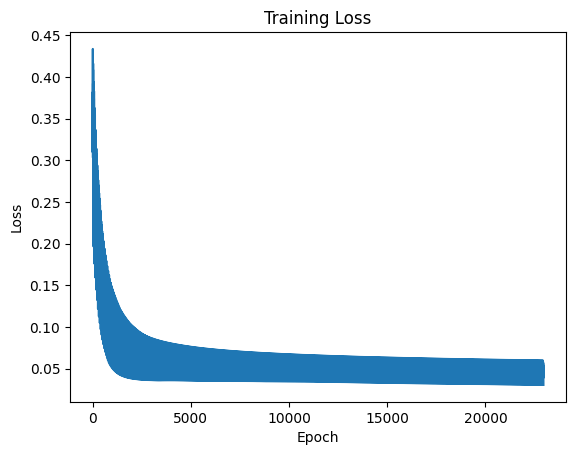

Text(0.5, 1.0, 'Validation Loss')

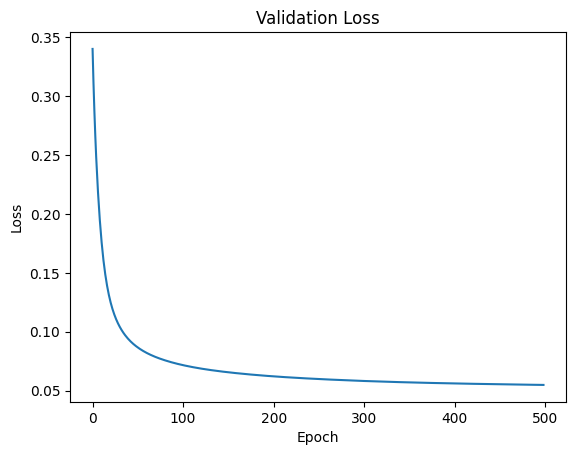

In [184]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define the model       
layers = [
    nn.Linear(13, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
    nn.Linear(32, 1),
]

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


EPOCHS = 5000
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
EARLY_STOPPING_THRESHOLD = 1e-5

training_samples = X_train_tensor.size(0)
batches_per_epoch = training_samples / BATCH_SIZE

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    training_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, training_samples, BATCH_SIZE):
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+BATCH_SIZE]
        y_batch = y_train_tensor[i:i+BATCH_SIZE]

        # Forward pass
        x = X_batch
        for layer in layers:
            x = layer(x)
        
        # Loss calculation
        loss = F.mse_loss(x.squeeze(), y_batch)
        
        # Clear gradients (ensure no accumulation of gradients)
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()
        for p in parameters:
            p.data -= LEARNING_RATE * p.grad

        # Track epoch loss
        training_loss += loss.item()
        training_losses.append(loss.item())     
    
    # # Validation loss
    with torch.no_grad():
        # Validation loss
        x = X_val_tensor
        for layer in layers:
            x = layer(x)
        val_loss = F.mse_loss(x.squeeze(), y_val_tensor)
        validation_losses.append(val_loss.item())
    
    # Early stopping
    if epoch > 5 and  abs(validation_losses[-1] - validation_losses[-2]) < EARLY_STOPPING_THRESHOLD:
        print(validation_losses[-1] - validation_losses[-2])
        print(f"Early stopping at epoch {epoch+1}, {validation_losses[-1]}, {validation_losses[-2]}")
        break
    
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Training loss: {training_loss/batches_per_epoch:.4f}", f"Validation Loss: {val_loss}")

plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')



In [185]:
import numpy as np

# Perform predictions on the validation dataset

with torch.no_grad():
    x = X_val_tensor
    for layer in layers:
        x = layer(x)

predictions = x.squeeze()


print(pd.DataFrame(predictions).describe())


print(predictions[0:10])
print(y_val_tensor[0:10])

# print(pd.DataFrame(predictions).describe())   
# print(pd.DataFrame(y_val_tensor).describe())

print(sum(predictions > 0.5))
print(sum(y_val_tensor > 0.5))




                 0
count  1443.000000
mean      0.445871
std       0.200500
min      -0.025083
25%       0.284128
50%       0.442587
75%       0.600833
max       1.212245
tensor([0.1896, 0.3627, 0.5476, 0.6442, 0.3600, 0.8068, 0.3416, 0.1942, 0.2379,
        0.3416])
tensor([0.1000, 0.3000, 0.4000, 1.0000, 0.1000, 1.0000, 0.5000, 0.1000, 0.2000,
        0.2000])
tensor(584)
tensor(524)


In [186]:

PROB_RECID_THRESHOLD = 0.5


def categorize_score(score):
    if score <= PROB_RECID_THRESHOLD:
        return 0
    else:
        return 1

# Add the predictions to the dataframe by mapping the categorize_score function to the predictions
# prediction values will be low, medium, or high
prob_recid_tensor = pd.Categorical(
    pd.Series(predictions).map(categorize_score),
)

print(torch.Tensor( predictions[0:10]))
preb_recid_tensor = torch.Tensor(prob_recid_tensor)
y_two_year_recid_tensor = torch.Tensor( y_two_year_recid_val_tensor)




# Initialize counters
counts = {
    "prob_recid": [0, 0, 1, 1],
    "y_two_year_recid_val": [0, 1, 0, 1],
    "count": [0, 0, 0, 0]
}

# Count occurrences
for p, y in zip(preb_recid_tensor, y_two_year_recid_tensor):
    if p == 0 and y == 0:
        counts["count"][0] += 1
    elif p == 0 and y == 1:
        counts["count"][1] += 1
    elif p == 1 and y == 0:
        counts["count"][2] += 1
    elif p == 1 and y == 1:
        counts["count"][3] += 1

# Create DataFrame
df_counts = pd.DataFrame(counts)

# Print DataFrame
print(df_counts)

TN = df_counts[(df_counts["prob_recid"] == 0) & (df_counts["y_two_year_recid_val"] == 0)]['count'].values[0]
FP = df_counts[(df_counts["prob_recid"] == 1) & (df_counts["y_two_year_recid_val"] == 0)]['count'].values[0]
FN = df_counts[(df_counts["prob_recid"] == 0) & (df_counts["y_two_year_recid_val"] == 1)]['count'].values[0]
TP = df_counts[(df_counts["prob_recid"] == 1) & (df_counts["y_two_year_recid_val"] == 1)]['count'].values[0]

Senstivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
Accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Senstivity: {Senstivity}")
print(f"Specificity: {Specificity}")
print(f"Precision: {Precision}")
print(f"Accuracy: {Accuracy}")

tensor([0.1896, 0.3627, 0.5476, 0.6442, 0.3600, 0.8068, 0.3416, 0.1942, 0.2379,
        0.3416])
   prob_recid  y_two_year_recid_val  count
0           0                     0    651
1           0                     1    208
2           1                     0    172
3           1                     1    412
Senstivity: 0.6645161290322581
Specificity: 0.7910085054678008
Precision: 0.7054794520547946
Accuracy: 0.7366597366597366
